In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("ticks")
sns.set_context("talk")

colors = sns.color_palette()

In [2]:
from numba import jit

# Exercise 1

In [3]:
# Parameters
D = 1        # Diffusion coefficient
L = 1001     # Number of grid points
DELTA = 0.1  # Grid spacing
TAU = 0.001  # Time step size
m = 10000    # Number of time steps

params = D, L, DELTA, TAU, m

In [4]:
@jit(nopython=True)
def compute_variance(phi, i_0, params):
    """
    Compute the variance of the distribution phi on the grid.
    """
    D, L, DELTA, TAU, m = params

    # Compute the mean of squared displacements and the mean displacement
    mean_xsq = DELTA**2 * np.sum((np.arange(L) - i_0)**2 * phi) / np.sum(phi)
    mean_x = DELTA * np.sum((np.arange(L) - i_0) * phi) / np.sum(phi)
    
    # Compute the variance
    variance = mean_xsq - mean_x**2
    return variance

@jit(nopython=True)
def evolve_and_compute_variances(phi, i_0, params):
    """
    Evolve the initial condition `phi` and compute the variances of the resulting distribution.
    """
    D, L, DELTA, TAU, m = params

    # Define the matrix X
    X = np.diag(np.ones(2)) + (-1) * np.diag(np.ones(1), k=1) + (-1) * np.diag(np.ones(1), k=-1)

    # Define the submatrices A and B
    a_A = -D * TAU / (2 * DELTA**2)
    submatrix_A = np.eye(2) + X / 2 * (np.exp(2 * a_A) - 1)

    a_B = -D * TAU / (DELTA**2)
    submatrix_B = np.eye(2) + X / 2 * (np.exp(2 * a_B) - 1)


    # Initialize the variances
    variances = np.zeros(m+1, dtype=np.float64)

    # Loop over the time steps
    for i in range(m+1):

        # Multiplication with first exponential of submatrix A
        phi[-1] = np.exp(a_A) * phi[-1]
        for j in range(0, L-1, 2):
            phi[j:j+2] = submatrix_A @ phi[j:j+2]

        # Multiplication with exponential of submatrix B
        phi[0] = np.exp(a_B) * phi[0]
        for j in range(1, L, 2):
            phi[j:j+2] = submatrix_B @ phi[j:j+2]

        # Multiplication with second exponential of submatrix A
        phi[-1] = np.exp(a_A) * phi[-1]
        for j in range(0, L-1, 2):
            phi[j:j+2] = submatrix_A @ phi[j:j+2]

        # Compute the variance
        variances[i] = compute_variance(phi, i_0, params)
    return variances

Initial conditions 1

In [5]:
# Initialize the distribution phi
phi = np.zeros(L, dtype=np.float64)

# Set the initial condition
i_0 = int((L+1)/2)
phi[i_0] = 1

# Time evolution and computation of variances
variances1 = evolve_and_compute_variances(phi, i_0, params)

Initial conditions 2

In [6]:
# Initialize the distribution phi
phi = np.zeros(L, dtype=np.float64)

# Set the initial condition
i_0 = int(0)
phi[i_0] = 1

# Time evolution and computation of variances
variances2 = evolve_and_compute_variances(phi, i_0, params)

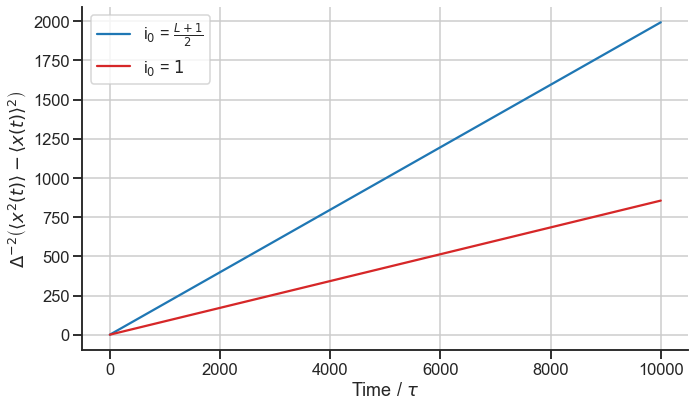

In [7]:
# Plot the variances

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(variances1 * DELTA ** (-2), label=r"i$_0$ = $\frac{L+1}{2}$", color=colors[0])
ax.plot(variances2 * DELTA ** (-2), label=r"i$_0$ = $1$", color=colors[3])

ax.set_xlabel(r"Time / $\tau$")
ax.set_ylabel(r"$\Delta^{-2} \left( \langle x^2(t) \rangle - \langle x(t) \rangle^2 \right)$")

ax.legend()
ax.grid()

plt.tight_layout()
sns.despine()
plt.savefig("figures/CP_exercise_7_A1.pdf")
plt.show()

# Exercise 2

In [8]:
# Simulation of random walks
N = 10**4           # Number of walkers
i_0 = int((L+1)/2)  # Initial position

# Initialize the positions
positions = i_0 * np.ones(N)

# Initialize the variances
variances = np.zeros(m+1)

# Loop over the time steps
for i in range(m+1):
    # Update the positions with random steps
    positions += np.random.choice([-1, 1], N)

    # Reflect the positions at the boundaries
    positions[positions <= -1] = 1
    positions[positions >= L + 1] = L - 1

    # Compute the variance
    variances[i] = np.mean((positions - i_0)**2) - np.mean(positions - i_0)**2

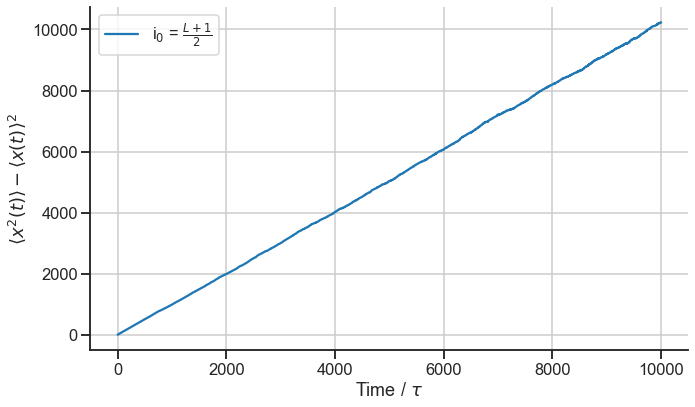

In [9]:
# Plot the variances

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(variances, label=r"i$_0$ = $\frac{L+1}{2}$", color=colors[0])

ax.set_xlabel(r"Time / $\tau$")
ax.set_ylabel(r"$\langle x^2(t) \rangle - \langle x(t) \rangle^2$")

ax.legend()
ax.grid()

plt.tight_layout()
sns.despine()
plt.savefig("figures/CP_exercise_7_A2.pdf")
plt.show()

In [10]:
# Compute the proportionality factor
proportionality = variances / (variances1  * DELTA ** (-2))

# Print the mean and standard deviation of the proportionality factor
print(f"D = {np.mean(proportionality):.3f} +/- {np.std(proportionality, ddof=1):.3f}")

# Expectation from diffusion equation
D_exp = DELTA**2 / (2 * TAU)
print(f"Expected value: {D_exp:.3f}")

D = 5.070 +/- 0.057
Expected value: 5.000
